In [1]:
from pathlib import Path
import xarray as xr
import f90nml
from pathlib import Path
import numpy as np
from dask_jobqueue import SLURMCluster
from distributed import Client
import cmocean.cm as cmo
import pvcalc

In [4]:
base_path = Path('/work/n01/n01/fwg/irminger-proj')
raw_path = base_path / 'data/raw'
interim_path = base_path / 'data/interim'
processed_path = base_path / 'data/processed'
figure_path = base_path / 'figures/200m'

run_path = raw_path / "3d-models-200m/dstandard"

In [5]:
data_nml = f90nml.read(run_path / "data")
delta_t = data_nml['parm03']['deltat']
f0 = data_nml['parm01']['f0']
beta = data_nml['parm01']['beta']
no_slip_bottom = data_nml['parm01']['no_slip_bottom']
no_slip_sides = data_nml['parm01']['no_slip_sides']

from xmitgcm import open_mdsdataset
ds_std = open_mdsdataset(run_path,
                        prefix=['ZLevelVars', 'IntLevelVars'],
                        delta_t=delta_t,
                        geometry='cartesian',
                        #iters=21600
                        #chunks=300
                        )

ds_std.attrs['f0'] = f0
ds_std.attrs['beta'] = beta
ds_std.attrs['no_slip_bottom'] = no_slip_bottom
ds_std.attrs['no_slip_sides'] = no_slip_sides

In [6]:
def prep_for_pv(ds):
    grid = pvcalc.create_xgcm_grid(ds)
    ds['drL'] = pvcalc.create_drL_from_dataset(ds)
    ds['rho'] = pvcalc.calculate_density(ds['RHOAnoma'], ds['rhoRef'])
    ds['b'] = pvcalc.calculate_buoyancy(ds['rho'])

    ds['db_dx'], ds['db_dy'], ds['db_dz'] = pvcalc.calculate_grad_buoyancy(ds['b'], ds, grid)
    
    db_dz_mask = xr.where(grid.interp(ds['maskC'],
                                      ['Z'],
                                      to={'Z': 'right'},
                                      boundary='fill') == 0,
                          np.nan,
                          1)

    ds['db_dz'] = ds['db_dz'] * db_dz_mask

    ds['zeta_x'], ds['zeta_y'], ds['zeta_z'] = pvcalc.calculate_curl_velocity(ds['UVEL'],
                                                                          ds['VVEL'],
                                                                          ds['WVEL'],
                                                                          ds,
                                                                          grid,no_slip_bottom,
                                                                          no_slip_sides
                                                                         )

    
    ds['NaNmaskC'] = xr.where(ds['maskC'] == 1, 1, np.NaN)
    
    ds['maskQ'] = grid.interp(ds['maskW'],
                              ['Y', 'Z'],
                              to={'Z': 'right', 'Y': 'left'},
                              boundary='fill')
    
    ds['NaNmaskQ'] = xr.where(ds['maskQ'] == 0, np.nan, 1)
    
    ds['Q'] = pvcalc.calculate_C_potential_vorticity(ds['zeta_x'],
                                                    ds['zeta_y'],
                                                    ds['zeta_z'],
                                                    ds['b'],
                                                    ds,
                                                    grid,
                                                    beta,
                                                    f0
                                                    ) * ds['NaNmaskQ']

    
    
    
    return ds, grid


ds_std, grid = prep_for_pv(ds_std)

In [7]:
base_path = Path('/work/n01/n01/fwg/irminger-proj')

log_path = base_path / 'src/post_processing/.tmp/slurm-out'
dask_worker_path = base_path / 'src/post_processing/.tmp/dask-worker-space'

env_path = base_path / 'irminger-proj/bin/activate'

scluster = SLURMCluster(queue='standard',
                        account="n01-siAMOC",
                        job_cpu=256,
                        log_directory=log_path,
                        local_directory=dask_worker_path,
                        cores=128,
                        processes=32,  # Can change this
                        memory="256 GiB",
                        job_directives_skip= ['#SBATCH --mem='],  
                        walltime="00:20:00",
                        death_timeout=60,
                        interface='hsn0',
                        job_extra_directives=['--qos=short', '--reservation=shortqos'],
                        job_script_prologue=['module load cray-python',
                                   'source {}'.format(str(env_path.absolute()))]
                       )

client = Client(scluster)
scluster.scale(jobs=1)

/work/n01/n01/fwg/irminger-proj/irminger-proj/lib/python3.8/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 44739 instead
  warnings.warn(


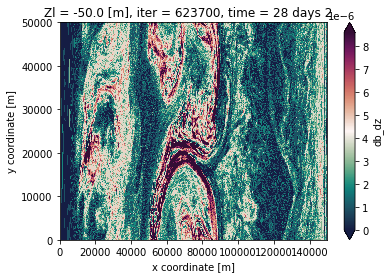

In [8]:
ds_std["db_dz"].isel(time=-1, Zl=50).plot(robust=True, cmap=cmo.curl)

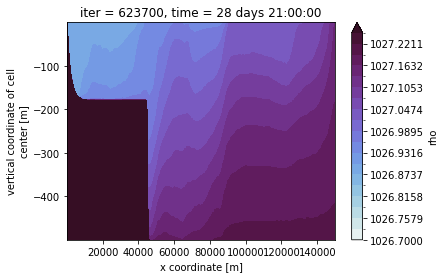

In [9]:
ds_std["rho"].isel(time=-1).mean(dim="YC").plot.contourf(levels=np.linspace(1026.7, 1027.25, 20), cmap=cmo.dense)

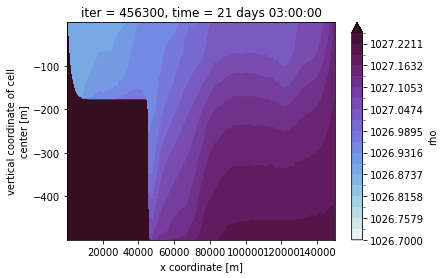

In [10]:
ds_std["rho"].isel(time=1).mean(dim="YC").plot.contourf(levels=np.linspace(1026.7, 1027.25, 20), cmap=cmo.dense)

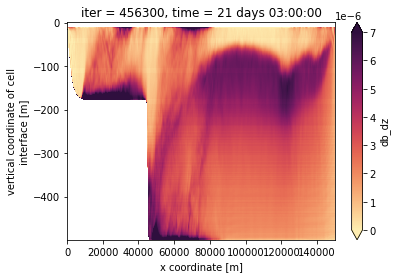

In [20]:
ds_std["db_dz"].isel(time=1).mean(dim="YC").rolling(Zl=12).mean().plot(cmap=cmo.matter, vmin=0, vmax=7e-6)

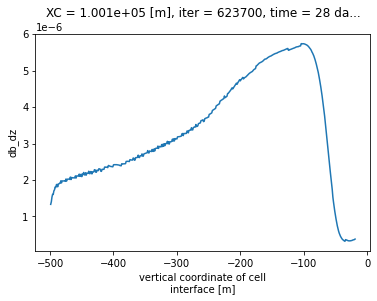

In [18]:
ds_std["db_dz"].isel(time=-1, XC=500).mean(dim="YC").rolling(Zl=20).mean().plot()#cmap=cmo.matter, vmin=0, vmax=7e-6)

In [18]:
scluster.close()

/work/n01/n01/fwg/irminger-proj/irminger-proj/lib/python3.8/site-packages/dask_jobqueue/core.py:255: FutureWarning: job_extra has been renamed to job_extra_directives. You are still using it (even if only set to []; please also check config files). If you did not set job_extra_directives yet, job_extra will be respected for now, but it will be removed in a future release. If you already set job_extra_directives, job_extra is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)
/work/n01/n01/fwg/irminger-proj/irminger-proj/lib/python3.8/site-packages/dask_jobqueue/core.py:274: FutureWarning: env_extra has been renamed to job_script_prologue. You are still using it (even if only set to []; please also check config files). If you did not set job_script_prologue yet, env_extra will be respected for now, but it will be removed in a future release. If you already set job_script_prologue, env_extra is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)
/work/n01